# Quantum Computing and Quantum Machine Learning - Project 1
## FYS5419/9419, University of Oslo, Spring 2025

### Abstract
...

### Introduction
...

In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import qiskit as qk
from qiskit_aer import Aer

In [11]:
# First some definitions of variables that we will use across the exercises
basis_0, basis_1 = np.array([1, 0]), np.array([0, 1])
Pauli_X = np.array([[0, 1], [1, 0]])
Pauli_Y = np.array([[0, -1j], [1j, 0]])
Pauli_Z = np.array([[1, 0], [0, -1]])
Id = np.array([[1, 0], [0, 1]])

CNOT = np.array([[1,0,0,0],
                 [0,1,0,0],
                 [0,0,0,1],
                 [0,0,1,0]])
CNOT_10 = np.array([[1,0,0,0],
                 [0,0,0,1],
                 [0,0,1,0],
                 [0,1,0,0]])
SWAP = np.array([[1,0,0,0],
                 [0,0,1,0],
                 [0,1,0,0],
                 [0,0,0,1]])
S_dag = np.array([[1, 0], [0, -1j]])

### Part a)

**Mathematical Background:**

Qubits are the fundamental building blocks of quantum computing. They serve as the quantum counterpart to classical bits and are the core units for both computation and information storage. A qubit consists of a two-level quantum system, such as the spin of an electron or the polarization of a photon, where the ground and excited states correspond to the classical values 0 and 1. Mathematically, these states are represented as two-dimensional vectors in the Hilbert space $\mathcal{H}$ of the qubit. 

It is common to define these states using the computational basis, which is given by the following two orthonormal vectors:
$$
\{|0\rangle = [1, 0]^T , |1\rangle = [0, 1]^T\}.
$$
This basis represents the simplest way to express any qubit state in the Hilbert space. A general qubit state can then be written as:
$$
|\psi \rangle = \alpha |0\rangle + \beta |1\rangle,
\tag{1}
$$
where $|\psi\rangle$ is the quantum state of the qubit, and $\alpha = \langle 0 | \psi \rangle$ and $\beta = \langle 1 | \psi \rangle$ are the complex amplitudes. These amplitudes are subject to the normalization condition $|\alpha|^2 + |\beta|^2 = 1$.

In a fully quantum scenario, the superposition described in Eq. (1) holds. However, when a qubit is measured or interacts with a classical system, the states' superposition is lost, causing the state to collapse on state $|0\rangle$ with probability $|\alpha|^2$ or on $|1\rangle$ with probability $|\beta|^2$. 

The computational basis is the most used, and it is not the only available for computation. In general, a basis for the qubit's Hilbert space can be every couple of state $|a\rangle$ and $|b\rangle$ fulfilling the orthonormality conditions $\langle a|b\rangle = 0$ and $\langle a|a\rangle = \langle b|b\rangle = 1$

If we fix one of the two complex phases, we can express the qubit state in polar form as
$$
|\psi \rangle = \cos\left(\frac{\theta}{2}\right) |0\rangle + e^{i\phi}\sin\left(\frac{\theta}{2}\right) |1\rangle,
\tag{2}
$$
where $\theta$ and $\phi$ are the spherical coordinates on the Bloch Sphere, which provides a geometrical representation of the qubit state. This state is represented as a point on the Bloch Sphere, and the qubit's state is visualized as a vector pointing from the origin to that point.

The qubit’s state can be manipulated by applying unitary rotations around the Bloch Sphere's axes, which are elements of the Lie algebra of $SU(2)$. The infinitesimal generators of these rotations are the Pauli matrices
$$
\sigma_x = X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}, \quad \sigma_y = Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}, \quad \sigma_z = Z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}, 
$$
and the rotation are then obtained through exponentiation
$$
R_x(\theta) = e^{-i\frac{\theta}{2} X}, \quad R_y(\theta) = e^{-i\frac{\theta}{2} Y}, \quad R_z(\theta) = e^{-i\frac{\theta}{2} Z}.
$$
The Pauli matrices, along with the identity matrix, form a basis of the complex $2\times 2$ matrices. As a consequence, a generic $2\times 2$ matrix $A$ can be uniquely decomposed as
$$
A = c_{I}Id + c_{X}X + c_{Y}Y + c_{Z}Z,
$$
where $c_{I}$, $c_{X}$, $c_{Y}$ and $c_{Z}$ are complex coefficients.

In quantum computing, all the unitary transformations acting on the qubit state are called Quantum gates. Along with the Pauli matrices $X$, $Y$, and $Z$, the Hadamard gate $H$ and the phase gate $S$ are fundamental gates acting on a single qubit. They are defined as

$$
H = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1  \\ 1 & -1 \end{bmatrix}, \quad S = \begin{bmatrix} 1 & 0 \\ 0 & i \end{bmatrix}.
$$

It is possible to define gates acting on two qubits, such as the two-qubits Hadamard gate or the CNOT gate:

$$
H \otimes H = \frac{1}{2} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \otimes \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} = \frac{1}{2} \begin{bmatrix} 1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1 \end{bmatrix}, \quad \text{CNOT} = \begin{bmatrix} 
1 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & 0 & 1 \\ 
0 & 0 & 1 & 0 
\end{bmatrix}
$$
The computational basis for the two-qubits state is then given by the tensor product of the computational basis of the single qubits:

$$
|00\rangle =|0\rangle \otimes |0\rangle= \begin{bmatrix} 
1 \\ 0 \\ 0 \\ 0 
\end{bmatrix}
\quad
|01\rangle =|0\rangle \otimes |1\rangle= \begin{bmatrix} 
0 \\ 1 \\ 0 \\ 0 
\end{bmatrix}
\quad
|10\rangle =|1\rangle \otimes |0\rangle= \begin{bmatrix} 
0 \\ 0 \\ 1 \\ 0 
\end{bmatrix}
\quad
|11\rangle =|1\rangle \otimes |1\rangle= \begin{bmatrix} 
0 \\ 0 \\ 0 \\ 1 
\end{bmatrix}
$$

Bell states are normalized linear combinations of the two-qubits computational basis. They are the maximally entangled (explain better entanglement??) quantum states of two qubits and defined as:

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle), \quad |\Phi^-\rangle = \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle)
$$
$$
|\Psi^+\rangle = \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle), \quad |\Psi^-\rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle)
$$

In [12]:
def apply_pauli_matrices_to_state(state, name):
    matrices = [Pauli_X, Pauli_Y, Pauli_Z]
    print("Basis state |" + name + ">:")
    print(state)
    print("\nApplying Pauli matrices to |" + name + ">:")
    for matrix in matrices:
        print(f"{matrix} |{name}> = {matrix @ state}")
    print("")

apply_pauli_matrices_to_state(basis_0, "0")
apply_pauli_matrices_to_state(basis_1, "1")

Basis state |0>:
[1 0]

Applying Pauli matrices to |0>:
[[0 1]
 [1 0]] |0> = [0 1]
[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]] |0> = [0.+0.j 0.+1.j]
[[ 1  0]
 [ 0 -1]] |0> = [1 0]

Basis state |1>:
[0 1]

Applying Pauli matrices to |1>:
[[0 1]
 [1 0]] |1> = [1 0]
[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]] |1> = [0.-1.j 0.+0.j]
[[ 1  0]
 [ 0 -1]] |1> = [ 0 -1]



In [13]:
# Moving on to Hadamard and phase gates:
Hadamard = (1 / sqrt(2)) * np.array([[1, 1], [1, -1]])

def apply_phase(phase, state):
    gate = np.array([[1, 0], [0, np.exp(1j * phase)]])
    return gate @ state

def print_result(func, name):
    result_0 = func(basis_0)
    result_1 = func(basis_1)
    print(name + " :")
    print(f"|0> = {result_0}")
    print(f"|1> = {result_1}")

print_result(lambda state: Hadamard @ state, "Hadamard")
print_result(lambda state: apply_phase(np.pi, state), "Phase")


Hadamard :
|0> = [0.70710678 0.70710678]
|1> = [ 0.70710678 -0.70710678]
Phase :
|0> = [1.+0.j 0.+0.j]
|1> = [ 0.+0.0000000e+00j -1.+1.2246468e-16j]


In [59]:
# Bell states and CNOT gate
bell_phi_p = (1 / sqrt(2)) * np.array([1, 0, 0, 1])
bell_phi_m = (1 / sqrt(2)) * np.array([1, 0, 0, -1])
bell_psi_p = (1 / sqrt(2)) * np.array([0, 1, 1, 0])
bell_psi_m = (1 / sqrt(2)) * np.array([0, 1, -1, 0])

hadamard_4D = np.kron(Hadamard, Id)

def apply_hadamard_and_cnot():
    bell_hadamard = hadamard_4D @ bell_phi_p
    print("Hadamard applied to Bell state Phi+: ")
    print(bell_hadamard)
    bell_hadamard_cnot = CNOT @ bell_hadamard
    print("CNOT + Hadamard applied to Bell state Phi+: ")
    print(bell_hadamard_cnot)
    return bell_hadamard_cnot

def measure(state, basis, shots):
    probabilities = np.abs(state.flatten())**2
    results = np.random.choice(basis, size=shots, p=probabilities)
    counts = {}
    for base in basis:
        counts[base] = (results == base).sum()
    return counts

bell_hadamard_cnot = apply_hadamard_and_cnot()
results = measure(bell_hadamard_cnot, ["00", "01", "10", "11"], 10000)
print(results)

# Comparison with Qiskit
def measure_bell_state(repetitions=10000):
    backend = Aer.get_backend('aer_simulator')
    qc = qk.QuantumCircuit(2, 2)
    
    # Create a bell state
    qc.h(0)
    qc.cx(0, 1)
    
    # Apply Hadamard and CNOT
    qc.h(0)
    qc.cx(0, 1)
    
    qc.measure([0, 1], [0, 1])
    compiled_circuit = qk.transpile(qc, backend)
    job = backend.run(compiled_circuit, shots=repetitions)
    results = job.result().get_counts()
    return results

print("With Qiskit:")
print(measure_bell_state())

Hadamard applied to Bell state Phi+: 
[ 0.5  0.5  0.5 -0.5]
CNOT + Hadamard applied to Bell state Phi+: 
[ 0.5  0.5 -0.5  0.5]
{'00': 2465, '01': 2484, '10': 2528, '11': 2523}
With Qiskit:
{'01': 2458, '00': 2519, '11': 2499, '10': 2524}


### Part b)

**Mathematical Background:**

The Hamiltonian $H$ is given by:

$$
H = H_0 + \lambda H_I
$$

where $H_0$ is the non-interacting Hamiltonian and $H_I$ is the interaction Hamiltonian. The eigenvalues of $H$ can be found by solving the characteristic equation:

$$
\det(H - h I) = 0
$$

**Analytical solution:**

Finding analytically the general eigenvalues of the Hamiltonian $H = H_0 + \lambda H_1$ requires solving the secular equation
$$ h^2 - D_1(\lambda)h + D_2(\lambda) = 0 $$

where
$$
D_1(\lambda) =E_0 + E_1 + \lambda(V_{11} + V_{22}) = {\rm Tr}[H_0]+\lambda{\rm Tr}[H_1],
$$ 
and 
$$
D_2(\lambda) = (E_0 + \lambda V_{11})(E_1 + \lambda V_{22}) - \lambda^2 V_{12}V_{21} = |H_0| + \lambda(E_0 V_{22} + E_1 V_{11})+\lambda^2 |H_1|.
$$
The eigenvaues are then

$$ 
h_{1,2}(\lambda) = \dfrac{D_1(\lambda)}{2}\mp\dfrac{1}{2}\sqrt{D_1^2(\lambda) - 4D_2(\lambda)}.
\tag{3}
$$

In the limit $\lambda\rightarrow 0$, the expression in Eq.(3) correctly gives the eigenvalues $h_1 = E_0$ and $h_2 = E_1$.

**Numerical solutions**

For the given parameters $E_1 = 0$, $E_2 = 4$, $V_{11} = 3$, $V_{22} = -3$, and $V_{12} = 0.2$, the eigenvalues are computed as functions of $\lambda$. The trace of this matrix is $4$, and its determinant is $3\lambda(4 - 3\lambda) - (0.2\lambda)$. Substituting this into the equation, we get

$$
\frac{1}{2} \left( 4 \pm \sqrt{16 - 4(3\lambda(4 - 3\lambda) - (0.2\lambda)^2)} \right)
= 2 \pm \frac{1}{2}\sqrt{4(4 - (3\lambda(4 - 3\lambda) - (0.2\lambda)^2))}
= 2 \pm \sqrt{4 - (3\lambda(4 - 3\lambda) - (0.2\lambda)^2)}
$$
and since $4 - 3\lambda(4 - 3\lambda) = 4 - 12\lambda + 9\lambda^2 = (3\lambda-2)^2$ we have
$$
2\pm \sqrt{4 - 12\lambda + 9\lambda^2 - (0.2\lambda)^2)}
= 2 \pm \sqrt{(3\lambda-2)^2 - (0.2\lambda)^2}
$$

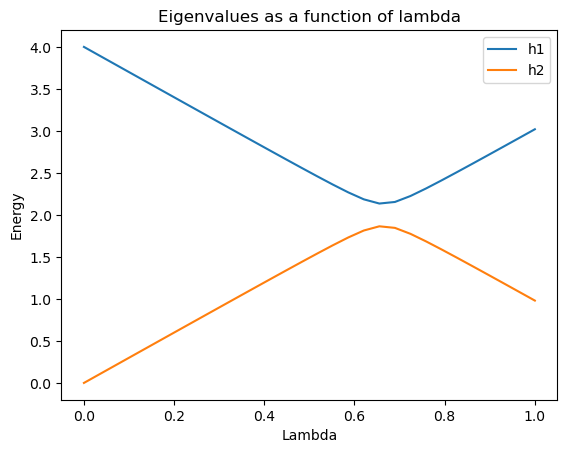

In [104]:
def EW_1(lambd):
    return 2 + sqrt((3 * lambd - 2)**2 + (0.2 * lambd) ** 2)

def EW_2(lambd):
    return 2 - sqrt((3 * lambd - 2)**2 + (0.2 * lambd) ** 2)

lambda_range = np.linspace(0.0, 1.0, 30)

def plot_eigenvalues():
    y_e1 = [EW_1(i) for i in lambda_range]
    y_e2 = [EW_2(i) for i in lambda_range]

    plt.plot(lambda_range, y_e1, label="h1")
    plt.plot(lambda_range, y_e2, label="h2")
    plt.legend()
    plt.xlabel("Lambda")
    plt.ylabel("Energy")
    plt.title("Eigenvalues as a function of lambda")
    plt.show()

plot_eigenvalues()

As expected, the total Hamiltonian $H$ has two non-degenerate eigenvalues for every value of the interaction strength $\lambda$. The ground state energy (labelled in orange in the above figure) monotonically increases until it reaches a global maximum, which, in turn, corresponds with the global minimum of the excited state (labelled in blue). For $\lambda = 0$, the Hamiltonian reduces to $H = H_0$ and the eigenvalues correctly coincide with the diagonal elements of $H_0$.

### Part c)

**Mathematical Background:**

The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm used to find the ground state energy of a certain Hamiltonian. This algorithm can also estimate the excited states after a proper redefinition of the Hamiltonian. The attribute hybrid comes from the fact that some of the computations are implemented on qubits of a quantum computer, whereas and data collection and optimization are done on a classical computer through classical algorithm. The main principle underlying the VQE is the Rayleigh–Ritz variational principle, through which one can estimate an upper bound for the ground state of the Hamiltonian. Explicitly, the expectation value of the Hamiltonian on a generic trial wavefunction $| \psi \rangle$ is always larger than the actual ground state energy, i.e.
$$
\frac{\langle\psi | H |\psi\rangle}{\langle\psi|\psi\rangle} \ge E_0,
$$
where the equality holds only when the wavefunction is the ground state's eigenvector. The VQE exploits this property to estimate the ground state energy. We can synthesize the algorithm in the following steps:
1. 
2.


The algorithm works by preparing a parameterized quantum state $|\psi(\theta)\rangle$ and minimizing the expectation value of the Hamiltonian:

$$
E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle
$$

The minimization is performed using classical optimization techniques.

First, let's start with some mathematics and helper functions, which will help to prepare qubit states with varying angles, and with transforming a given Pauli string into the Z basis:

In [65]:
def Rx(theta):
    return np.cos(theta/2) * Id - 1j * np.sin(theta/2) * Pauli_X

def Ry(phi):
    return np.cos(phi/2) * Id - 1j * np.sin(phi/2) * Pauli_Y

def prepare_state_1_qubit(args):
    state = np.array([1, 0])
    theta = args[0]
    phi = args[1]
    rx = Rx(theta)
    ry = Ry(phi)
    state = ry @ rx @ state
    return state

def transform_to_Z_basis(pauli_string):
    gates = {
        "X": Hadamard,
        "ZI": np.kron(Id, Id),
        "IZ": SWAP,
        "XI": np.kron(Hadamard, Id),
        "IX": np.kron(Hadamard, Id) @ SWAP,
        "YI": np.kron(S_dag @ Hadamard, Id),
        "IY": np.kron(S_dag @ Hadamard, Id) @ SWAP,
        "ZZ": CNOT_10,
        "XX": CNOT_10 @ np.kron(Hadamard, Hadamard),
        "YY": CNOT_10 @ np.kron(S_dag @ Hadamard, S_dag @ Hadamard),
        "ZX": CNOT_10 @ np.kron(Id, Hadamard),
        "XZ": CNOT_10 @ np.kron(Id, Hadamard) @ SWAP
    }
    return gates.get(pauli_string, None)

Now for the actual VQE implementation, in which the ground state energy is inferred by means of transforming the Hadamard matrix into Pauli matrices in the Z basis.
The minimization process uses gradient descend to infer the optimal eigenvector angles. 

In [66]:
# Now for the actual VQE implementation:
def minimize_energy(get_energy_func, lmb, number_shots, angles_0, learning_rate, max_epochs):
    angles = angles_0
    epoch = 0
    delta_energy = 1
    energy = get_energy(angles, lmb, number_shots)
    while (epoch < max_epochs) and (delta_energy > 1e-4):
        grad = np.zeros_like(angles)
        for idx in range(angles.shape[0]):
            angles_temp = angles.copy()
            angles_temp[idx] += np.pi/2 
            E_plus = get_energy_func(angles_temp, lmb, number_shots)
            angles_temp[idx] -= np.pi
            E_minus = get_energy_func(angles_temp, lmb, number_shots)
            grad[idx] = (E_plus - E_minus)/2 
        angles -= learning_rate*grad
        new_energy = get_energy_func(angles, lmb, number_shots)
        delta_energy = np.abs(new_energy - energy)
        energy = new_energy
        epoch += 1
    return angles, epoch, (epoch < max_epochs), energy, delta_energy

def VQE(get_energy_func, n_angles):
    number_shots_search = 10_000
    learning_rate = 0.3
    max_epochs = 400
    min_energy = np.zeros(len(lambda_range))
    epochs = np.zeros(len(lambda_range))
    for index, lmb in enumerate(lambda_range):
        memory = 0
        angles_0 = np.random.uniform(low = 0, high = np.pi, size = n_angles)
        angles, epochs[index], converged, min_energy[index], delta_energy = minimize_energy(get_energy_func, lmb, number_shots_search, angles_0, learning_rate, max_epochs)
        if epochs[index] < (epochs[index-1] - 5):
            angles_0 = np.random.uniform(low = 0, high = np.pi, size = n_angles)
            angles, epochs[index], converged, min_energy[index], delta_energy = minimize_energy(get_energy_func, lmb, number_shots_search, angles_0, learning_rate, max_epochs)
        print(f'Lambda = {lmb}, Energy = {min_energy[index]}, Epochs = {epochs[index]}, Converged = {converged}, Delta Energy = {delta_energy}, Angles = {angles}')
    return min_energy

We will also write functions which minimizes the energy using a scipy minimizer, and one which simply finds all eigenvalues of the hamiltonian:

In [67]:
def minimize_energy_scipy(energy_fnc):
    number_shots = 10_000
    min_energy = np.zeros(len(lambda_range))
    for index, lmb in enumerate(lambda_range):
        angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
        res = minimize(energy_fnc, angles_start, args = (lmb, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
        min_energy[index] = res.fun
    return min_energy
    

def find_eigenvalues_scipy(hamiltonian_func):
    h_len = len(hamiltonian_func(0))
    eigvals = np.zeros((len(lambda_range), h_len))
    for index, lmb in enumerate(lambda_range):
        H = hamiltonian_func(lmb)
        eigen, _ = np.linalg.eigh(H)
        eigvals[index] = eigen
    return eigvals

def plot_results(min_energy_VQE, min_energy_scipy=np.array(0), eigvals_ana=np.array(0)):
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    if eigvals_ana.any():
        for i in range(len(eigvals_ana[0,:])):
            axs.plot(lambda_range, eigvals_ana[:,i], label=f'$E_{i+1}$')
    if min_energy_VQE.any():
        axs.scatter(lambda_range, min_energy_VQE, label = 'VQE eigenvalues', color = '#dd8452')
    if min_energy_scipy.any():
        axs.scatter(lambda_range, min_energy_scipy, label = 'VQE Scipy', color = '#55a868')
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel('Energy')
    plt.legend()
    plt.show()

def perform_VQE_and_plot_results(get_energy_func, n_angles, create_Hamiltonian_func):
    min_energy = VQE(get_energy_func, n_angles)
    min_energy_scipy = minimize_energy_scipy(get_energy_func)
    eigvals_ana = find_eigenvalues_scipy(create_Hamiltonian_func)
    plot_results(min_energy_VQE=min_energy, min_energy_scipy=min_energy_scipy, eigvals_ana=eigvals_ana)



Now we will define an energy function to minimize and actually call VQE and the other ways to minimize the energy. The energy function is given by the Pauli decomposition of the Hamiltonian(s)
$$
H_0 = \mathcal{E}I + \Omega\sigma_z, \quad \mathcal{E} = \frac{E_1 + E_2}{2}, \quad \Omega = \frac{E_1 - E_2}{2}, \quad H_I = cI + \omega_z\sigma_z + \omega_x\sigma_x
$$
which implies that
$$
H = (\mathcal{E}+ \lambda c)I + (\Omega + \lambda\omega_z)\sigma_z + \sigma_z + \lambda\omega_x\sigma_x
$$

So, in order to find the ground-state energy (find the lowest eigenvalue), we decompose our Hamiltonian according to the above equation, and find the eigenvalues of the individual pauli matrices. Since measurements may only be possible in the Z basis, we have to transform all gates into this basis first.
$$
\begin{align*}
E_{\psi}(\sigma)
&= \langle \psi\vert\sigma\vert\psi\rangle \nonumber \\
&=\langle\psi\vert R_{\sigma}^{\dagger}ZR_{\sigma}\vert\psi\rangle =\langle \phi\vert Z\vert \phi\rangle \nonumber \\
&=\langle\phi\vert\left(\sum_{x\in\{0,1\}}(-1)^x\vert x\rangle\langle x\vert\right)\vert\phi\rangle \nonumber \\
&=\sum_{x\in\{0,1\}}(-1)^x\vert\langle x\vert \phi\rangle\vert^2\nonumber \\
&=\sum_{x\in\{0,1\}}(-1)^xP(\vert \phi\rangle\to\vert x\rangle) \\
&=P(\vert \phi\rangle\to\vert 0\rangle) - P(\vert \phi\rangle\to\vert 1\rangle) \\
\end{align*}
$$

where $\vert \phi\rangle=\vert R_\sigma\phi\rangle$ and
$P(\vert \phi\rangle\to\vert x\rangle$ is the probability that the state
$\vert \phi\rangle$ collapses to the state $\vert x\rangle$ when measured.

This can be extended to an arbitrary string of Pauli operators $P=\bigotimes_{p\in Q}\sigma_p$ (see lecture) and due to the linearity of expectation values $E_\psi\left(\sum_{m}\lambda_mP_m\right) = \sum_m\lambda_mE_\psi(P_m)$ it follows that in order to find the expectation value of the Hamiltonian, we sum the expectation values of the individual Pauli matrices of our decomposition, which we find by 
- finding the matrices which transform the basis which we're working in (Pauli-Z) into the given Pauli matrix, e.g. $X = HZH$ with $H$ being the Hadamard matrix
- multiplying them with our initial state (giving us the amount of $0$ measurements $N_0$ and $1$ measurements $N_1$)
- calculating $\frac{N_0 - N_1}{N_0 + N_1}$ (the expectation value of a state in the Pauli-Z basis)
- multiplying with the respective $\lambda_m$

Thus giving us the following get_energy function:

In [105]:
# Constants
E_1 = 0
E_2 = 4
V_11 = 3
V_22 = -3
V_12 = 0.2
V_21 = V_12
eps = (E_1 + E_2) / 2
omega = (E_1 - E_2) / 2
c = (V_11 + V_22) / 2
omega_z = (V_11 - V_22) / 2
omega_x = V_12

# get_energy will be used by the VQE gradient descent algorithm, and by the minimize_energy_scipy function
def get_energy(angles, lmb, number_shots):
    theta, phi = angles[0], angles[1]
    init_state = prepare_state_1_qubit([theta, phi])

    # expected value of Z = (number of 0 measurements - number of 1 measurements)/ number of shots
    measure_z = measure(init_state, ["0", "1"], number_shots)
    exp_val_z = (omega + lmb*omega_z)*(number_shots - 2*measure_z["1"]) / number_shots

    measure_x = measure(transform_to_Z_basis("X") @ init_state, ["0", "1"], number_shots)
    exp_val_x = lmb*omega_x*(number_shots - 2*measure_x["1"]) / number_shots
    
    exp_val_i = (eps + c*lmb)
    exp_val = (exp_val_z + exp_val_x + exp_val_i)
    return exp_val

We also define functions for creating the actual Hamiltonian with untransformed Pauli-Z gates, so that we can find its eigenvalues using the find_eigenvalues_scipy function:

In [106]:
def create_Hamiltonian_from_pauli_gates(x=0, y=0, z=0, I=0):
    return (x * Pauli_X) + (y * Pauli_Y) + (z * Pauli_Z) + (I * Id)
H_0 = create_Hamiltonian_from_pauli_gates(z=omega, I=eps)
H_1 = create_Hamiltonian_from_pauli_gates(x=omega_x, z=omega_z, I=c)

# This function will be used by find_eigenvalues_scipy, which simply calculates eigenvalues using np.linalg.eigh
def create_Hamiltonian_with_interaction(lambd):
    return H_0 + lambd * H_1

Lambda = 0.0, Energy = 0.0, Epochs = 10.0, Converged = True, Delta Energy = 0.0, Angles = [3.14333276 3.13694643]
Lambda = 0.034482758620689655, Energy = 0.1033503448275861, Epochs = 16.0, Converged = True, Delta Energy = 2.6206896551750347e-05, Angles = [3.14165724 3.13743829]
Lambda = 0.06896551724137931, Energy = 0.20698482758620695, Epochs = 14.0, Converged = True, Delta Energy = 5.5172413793158626e-06, Angles = [3.13148485 3.13081529]
Lambda = 0.10344827586206896, Energy = 0.3100262068965516, Epochs = 9.0, Converged = True, Delta Energy = 1.241379310346069e-05, Angles = [-0.00208703 -0.01470568]
Lambda = 0.13793103448275862, Energy = 0.4137296551724139, Epochs = 19.0, Converged = True, Delta Energy = 9.931034482768553e-05, Angles = [ 0.00808158 -0.01670015]
Lambda = 0.1724137931034483, Energy = 0.5168827586206894, Epochs = 14.0, Converged = True, Delta Energy = 4.137931034486897e-05, Angles = [ 0.0055381  -0.02543974]
Lambda = 0.20689655172413793, Energy = 0.6199034482758621, Epoc

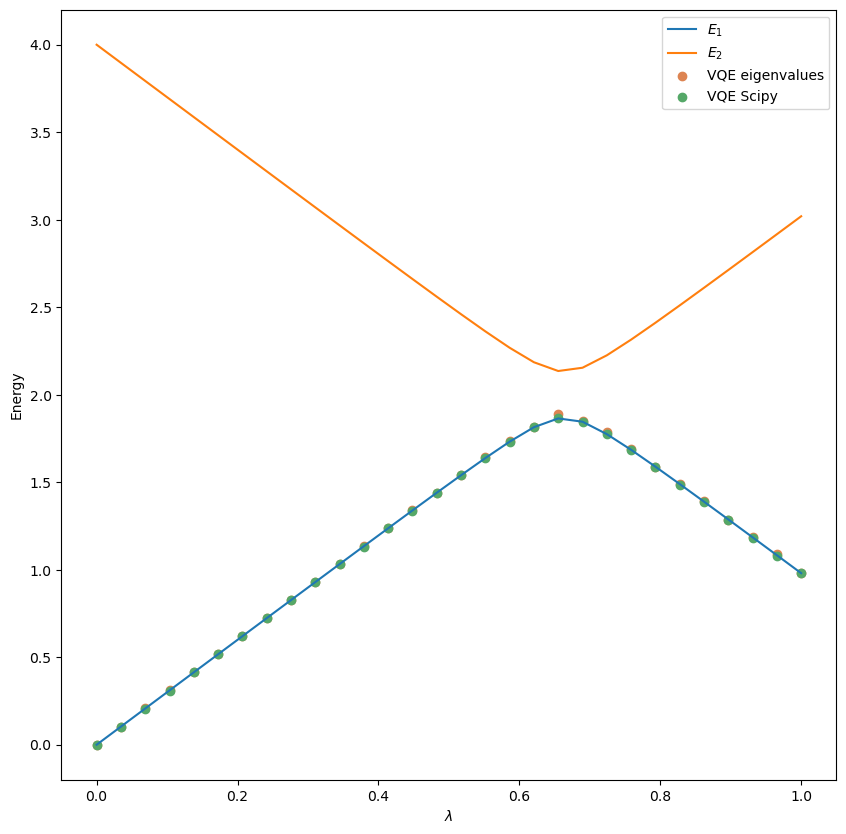

In [107]:
perform_VQE_and_plot_results(get_energy, 2, create_Hamiltonian_with_interaction)

### Part d)

The two-qubit system Hamiltonian is now given by:

$$
H = 
\begin{bmatrix}
\epsilon_{00} + H_z & 0 & 0 & H_x \\
0 & \epsilon_{10} - H_z & H_x & 0 \\
0 & H_x & \epsilon_{01} - H_z & 0 \\
H_x & 0 & 0 & \epsilon_{11} + H_z
\end{bmatrix}
= H_0 + H_1
$$

with $H_0 = diag(\epsilon_{00}, \epsilon_{10}, \epsilon_{01}, \epsilon_{11})$ and $H_1 = H_x \sigma_x \otimes \sigma_x + H_z \sigma_z \otimes \sigma_z$

where $H_0$ is the non-interacting Hamiltonian and $H_I$ is the interaction Hamiltonian. The von Neumann entropy is used to measure entanglement and is defined as:

$$
S(A, B) = -\operatorname{Tr}\left(\rho_{A, B} \log_2 (\rho_{A, B})\right).
$$



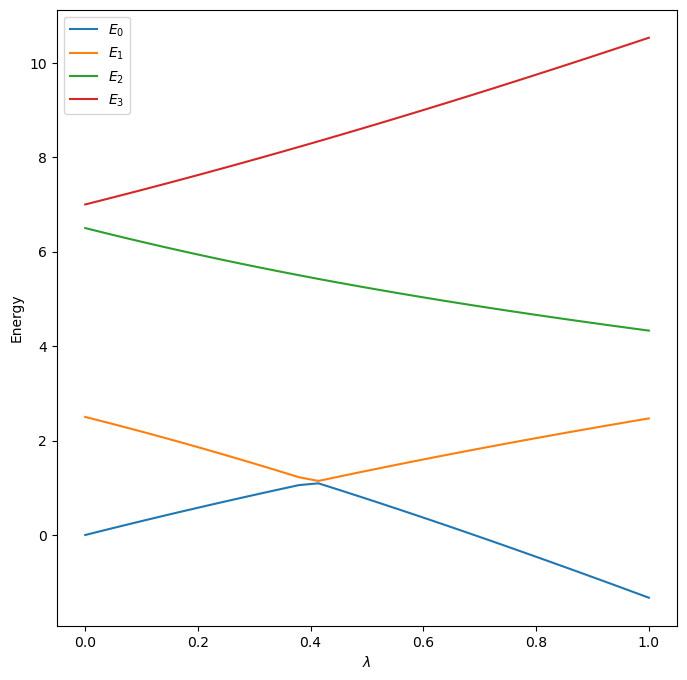

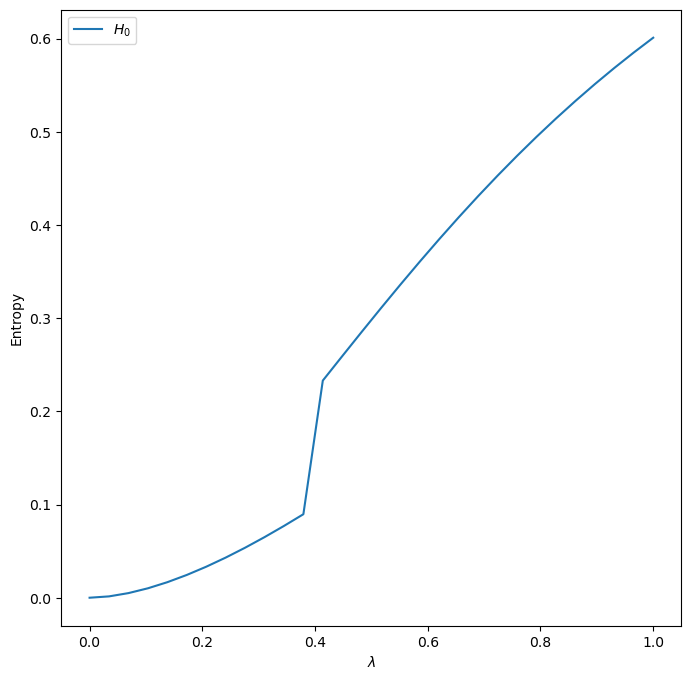

In [72]:
# Part d) Two-qubit system and von Neumann entropy

Hx = 2.0
Hz = 3.0
Energiesnoninteracting = [0.0, 2.5, 6.5, 7.0]
H_0 = np.diag(Energiesnoninteracting)
H_1 = Hx * np.kron(Pauli_X, Pauli_X) + Hz * np.kron(Pauli_Z, Pauli_Z)

def trace_out(state, index):
    density = np.outer(state, np.conj(state))
    if index == 0:
        op0 = np.kron(basis_0, Id)
        op1 = np.kron(basis_1, Id)
    elif index == 1:
        op0 = np.kron(Id, basis_0)
        op1 = np.kron(Id, basis_1)
    return op0.conj() @ density @ op0.T + op1.conj() @ density @ op1.T

eigenvalues = []
entropy = np.zeros((len(lambda_range), 4))
for index, lmb in enumerate(lambda_range):
    Hamilt = create_Hamiltonian(lmb)
    eigvals, eigvecs = np.linalg.eigh(Hamilt)
    eigenvalues.append(eigvals)
    for i in range(4):
        sub_density = trace_out(eigvecs[:, i], 0)
        lmb_density = np.linalg.eigvalsh(sub_density)
        lmb_density = np.ma.masked_equal(lmb_density, 0).compressed()
        entropy[index, i] = -np.sum(lmb_density*np.log2(lmb_density))
eigenvalues = np.array(eigenvalues)

def plot_energies_and_entropy():
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    for i in range(4):
        axs.plot(lambda_range, eigenvalues[:, i], label=f'$E_{i}$')
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel('Energy')
    axs.legend()
    plt.show()

    fig, axs = plt.subplots(1, 1, figsize=(8, 8))
    for i in range(1):
        axs.plot(lambda_range, entropy[:, i], label=f'$H_{i}$')
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel('Entropy')
    axs.legend()
    plt.show()

plot_energies_and_entropy()

### Part e) (Score: 15pt)

**Mathematical Background:**

The VQE algorithm is extended to a two-qubit system. The Hamiltonian is now a 4x4 matrix, and the expectation value of the Hamiltonian is computed using a parameterized two-qubit state.

Lambda = 0.0, Energy = 0.0005500000000000504, Epochs = 24.0, Converged = True, Delta Energy = 4.999999999988347e-05, Angles = [3.13295479 3.1457925  3.13450316 3.13669312]
Lambda = 0.034482758620689655, Energy = 0.10464827586206882, Epochs = 13.0, Converged = True, Delta Energy = 1.7241379310029004e-05, Angles = [3.14387375 3.12397892 3.11553629 3.11383953]
Lambda = 0.06896551724137931, Energy = 0.20297068965517262, Epochs = 36.0, Converged = True, Delta Energy = 5.862068965489797e-05, Angles = [3.14682964 3.11053373 3.14290962 3.14187958]
Lambda = 0.10344827586206896, Energy = 0.3040275862068973, Epochs = 101.0, Converged = True, Delta Energy = 1.034482758610622e-05, Angles = [ 3.13574326e+00  3.07721287e+00 -1.52035185e-04  2.04041523e-03]
Lambda = 0.13793103448275862, Energy = 0.3993637931034484, Epochs = 99.0, Converged = True, Delta Energy = 9.999999999976694e-05, Angles = [ 3.13954830e+00  3.06674994e+00  4.94206595e-04 -1.88504600e-03]
Lambda = 0.1724137931034483, Energy = 0.498

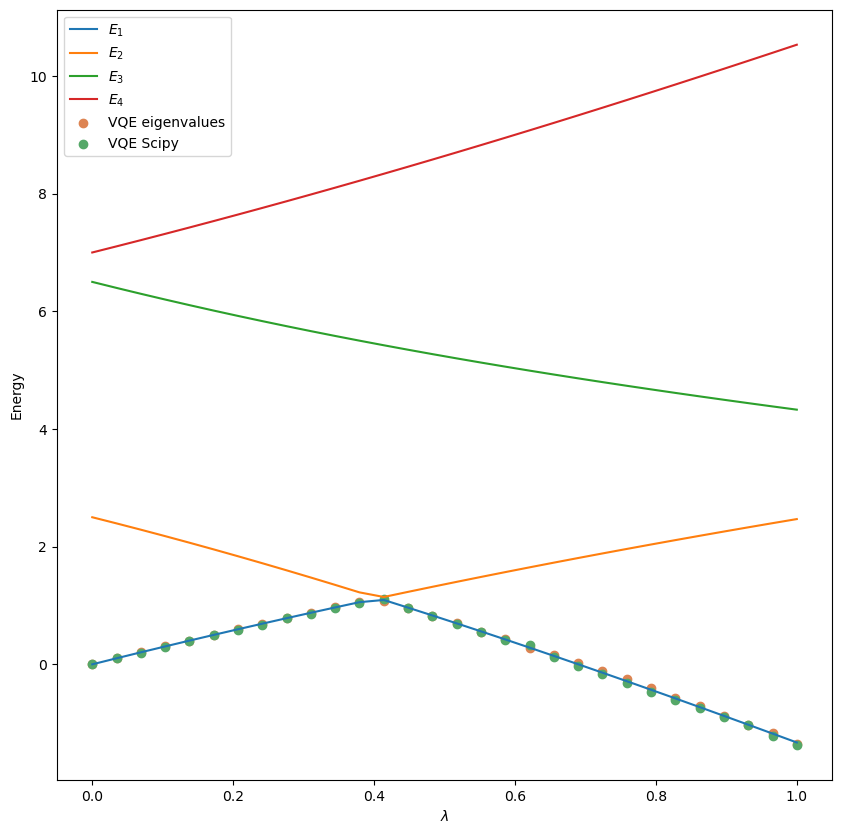

In [75]:
# Part e) VQE for two-qubit system

def apply_to_qubit(operator, qubit_index):
    if qubit_index == 0:
        return np.kron(operator, Id)
    elif qubit_index == 1:
        return np.kron(Id, operator)

def prepare_state_2_qubit(args):
    theta0, phi0, theta1, phi1 = args[0], args[1], args[2], args[3]
    qubit = np.array([1, 0, 0, 0])
    Rx0 = Rx(theta0)
    Ry0 = Ry(phi0)
    Rx1 = Rx(theta1)
    Ry1 = Ry(phi1)
    state = apply_to_qubit(Rx0, 0) @ qubit
    state = apply_to_qubit(Ry0, 0) @ state
    state = apply_to_qubit(Rx1, 1) @ state
    state = apply_to_qubit(Ry1, 1) @ state
    return CNOT @ state

def get_energy(angles, lmb, number_shots):
    Hx = 2.0 
    Hz = 3.0
    eps00, eps01, eps10, eps11 = np.array([0.0, 2.5, 6.5, 7.0])
    A = (eps00 + eps01 + eps10 + eps11) / 4.0
    B = (eps00 - eps01 + eps10 - eps11) / 4.0
    C = (eps00 + eps01 - eps10 - eps11) / 4.0
    D = (eps00 - eps01 - eps10 + eps11) / 4.0
    
    init_state = prepare_state_2_qubit(angles)

    measure_iz = measure(transform_to_Z_basis("IZ") @ init_state, ["00", "01", "10", "11"], number_shots)
    measure_zi = measure(init_state, ["00", "01", "10", "11"], number_shots)
    measure_zz = measure(transform_to_Z_basis("ZZ") @ init_state, ["00", "01", "10", "11"], number_shots)
    measure_xx = measure(transform_to_Z_basis("XX") @ init_state, ["00", "01", "10", "11"], number_shots)
    
    exp_vals = np.zeros(4)
    measures = np.array([measure_iz, measure_zi, measure_zz, measure_xx])
    constants = np.array([B, C, D + lmb*Hz, lmb*Hx])
    for index in range(len(exp_vals)):
        exp_vals[index] = measures[index]["00"] + measures[index]["01"] - measures[index]["10"] - measures[index]["11"]
    exp_val = A + np.sum(constants * exp_vals) / number_shots
    return exp_val

perform_VQE_and_plot_results(get_energy, 4, create_Hamiltonian)

### Part f) (Score: 20pt)

**Mathematical Background:**

The Lipkin Hamiltonian for $J=1$ and $J=2$ is given by:

$$
H_{J=1} = \begin{pmatrix} -\epsilon & 0 & -V \\ 0 & 0 & 0 \\ -V & 0 & \epsilon \end{pmatrix}, \quad H_{J=2} = \begin{pmatrix} -2\epsilon & 0 & \sqrt{6}V & 0 & 0 \\ 0 & -\epsilon + 3W & 0 & 3V & 0 \\ \sqrt{6}V & 0 & 4W & 0 & \sqrt{6}V \\ 0 & 3V & 0 & \epsilon + 3W & 0 \\ 0 & 0 & \sqrt{6}V & 0 & 2\epsilon \end{pmatrix}
$$

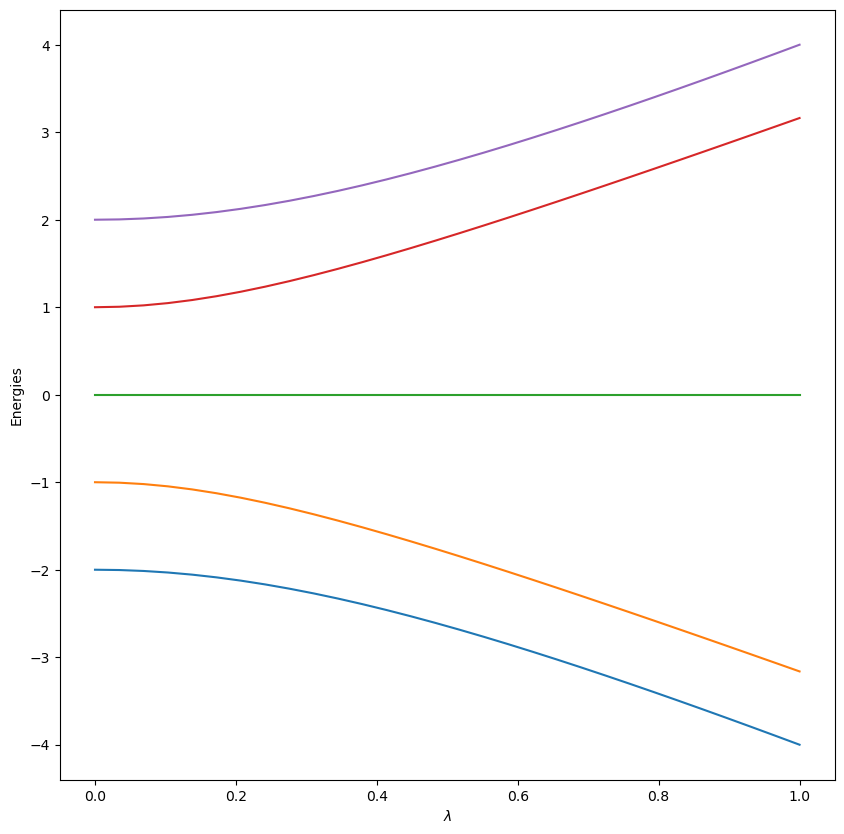

In [108]:
# Part f) Lipkin Hamiltonian for J=1 and J=2

epsilon = 1
H_0 = epsilon * np.diag([-2, -1, 0, 1, 2])

H_1 = np.zeros((5, 5))
H_1[2, 0] = np.sqrt(6)
H_1[3, 1] = 3
H_1[4, 2] = H_1[2, 0]
H_1 = H_1 + H_1.T

eigvals = find_eigenvalues_scipy(create_Hamiltonian)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for i in range(5):
    axs.plot(lambda_range, eigvals[:,i], label=f'$E_{i+1}$')
    axs.set_xlabel(r'$\lambda$')
    axs.set_ylabel("Energies")
plt.show()

### Part g) (Score: 20pt)

**Mathematical Background:**

The VQE algorithm is applied to the Lipkin Hamiltonian for $J=1$ and $J=2$. The Hamiltonian is rewritten in terms of Pauli matrices, and the eigenvalues are computed using the VQE method.

Lambda = 0.0, Energy = -2.0, Epochs = 27.0, Converged = True, Delta Energy = 0.0, Angles = [3.14026041 3.13555953 3.13525286 3.13865256]
Lambda = 0.034482758620689655, Energy = -2.0034531384947805, Epochs = 55.0, Converged = True, Delta Energy = 5.3692829468321435e-05, Angles = [ 3.19722642e-04 -3.98740092e-03  3.14134248e+00  3.05460593e+00]
Lambda = 0.06896551724137931, Energy = -2.0114315687266653, Epochs = 62.0, Converged = True, Delta Energy = 3.438074308936834e-05, Angles = [2.90405748e-03 1.10116683e-02 3.14278494e+00 2.97251927e+00]
Lambda = 0.10344827586206896, Energy = -2.0317506970341843, Epochs = 96.0, Converged = True, Delta Energy = 2.716392506219023e-05, Angles = [0.00494602 0.01820659 3.1434456  2.88607614]
Lambda = 0.13793103448275862, Energy = -2.055181792112129, Epochs = 96.0, Converged = True, Delta Energy = 4.889506511140951e-05, Angles = [ 3.26234706e-04  2.97434993e-02 -5.38117362e-04  5.95525464e+00]
Lambda = 0.1724137931034483, Energy = -2.087925488981154, Epoc

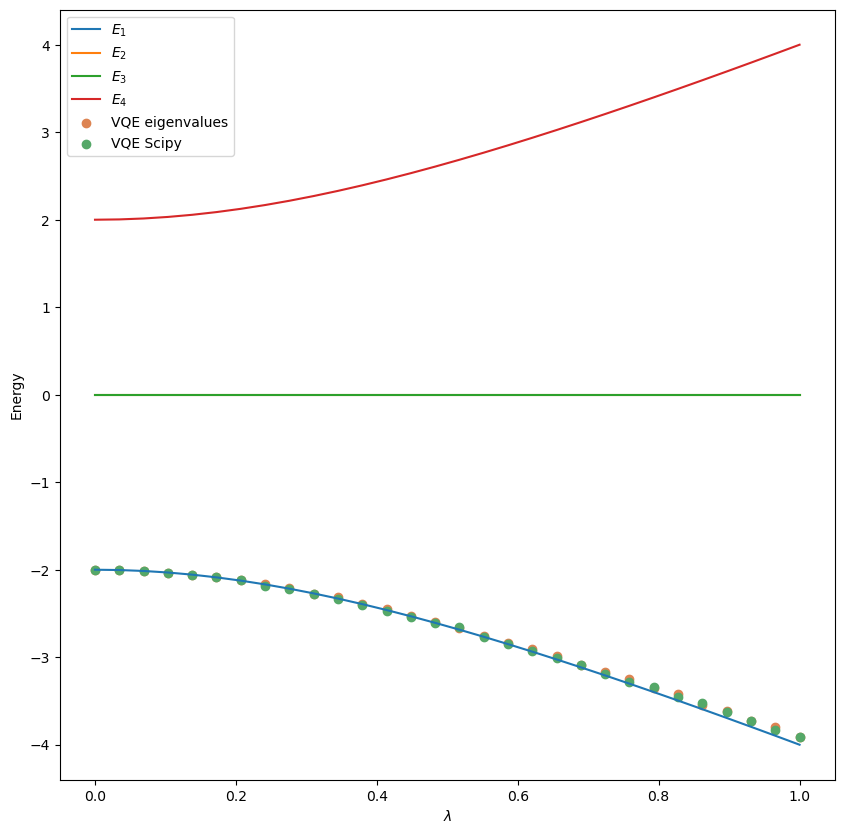

Lambda = 0.0, Energy = -1.0, Epochs = 25.0, Converged = True, Delta Energy = 0.0, Angles = [3.13523988 0.00818101]
Lambda = 0.034482758620689655, Energy = -1.003006896551724, Epochs = 26.0, Converged = True, Delta Energy = 3.448275862072414e-05, Angles = [3.14133948 0.10286231]
Lambda = 0.06896551724137931, Energy = -1.0217724137931035, Epochs = 43.0, Converged = True, Delta Energy = 6.896551724144828e-06, Angles = [3.14542014 0.20284392]
Lambda = 0.10344827586206896, Energy = -1.0439103448275862, Epochs = 34.0, Converged = True, Delta Energy = 0.0, Angles = [3.13840715 0.30224482]
Lambda = 0.13793103448275862, Energy = -1.0869241379310344, Epochs = 49.0, Converged = True, Delta Energy = 5.5172413793158626e-05, Angles = [3.14234956 0.39137857]
Lambda = 0.1724137931034483, Energy = -1.1290275862068966, Epochs = 99.0, Converged = True, Delta Energy = 6.896551724144828e-05, Angles = [2.06318117e-03 3.61472279e+00]
Lambda = 0.20689655172413793, Energy = -1.179351724137931, Epochs = 203.0, 

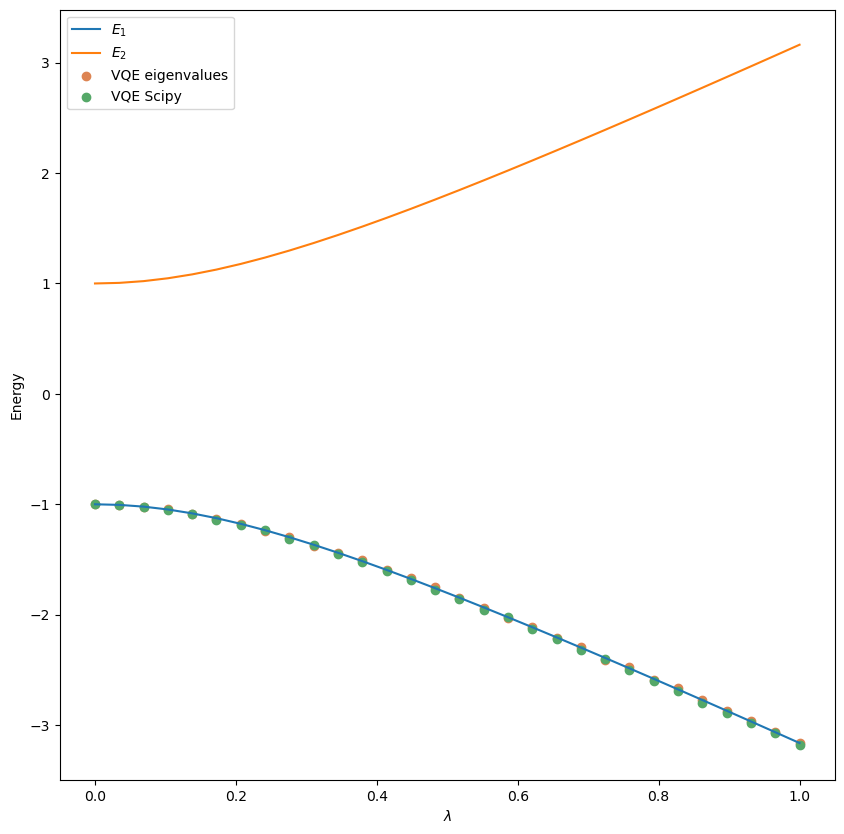

In [80]:
# Part g) VQE for Lipkin Hamiltonian

E, W = 1, 0
def Hamiltonian(lambd):
    V = lambd
    term1 = W * np.kron(Id, Id)
    term2 = (W-E) * np.kron(Pauli_Z, Id)
    term3 = -(W+E) * np.kron(Id, Pauli_Z)
    term4 = -W * np.kron(Pauli_Z, Pauli_Z)
    term5 = np.sqrt(6)/2*V * np.kron(Id, Pauli_X)
    term6 = np.sqrt(6)/2*V * np.kron(Pauli_X, Id)
    term7 = np.sqrt(6)/2*V * np.kron(Pauli_Z, Pauli_X)
    term8 = -np.sqrt(6)/2*V * np.kron(Pauli_X, Pauli_Z)
    
    H_135= term1+term2+term3+term4+term5+term6+term7+term8
    H_24=3*W*Id-E*Pauli_Z+3*V*Pauli_X
    return H_135, H_24

def get_energy(angles, lmb, number_shots):
    V = lmb
    init_state = prepare_state_2_qubit(angles)
    pauli_strings = ["ZI", "IZ", "ZZ", "IX", "XI", "ZX", "XZ"]
    measurements = []
    for p_str in pauli_strings:
        qubit = transform_to_Z_basis(p_str) @ init_state
        measurements.append(measure(qubit, ["00", "01", "10", "11"], number_shots))
    
    exp_vals = np.zeros(len(measurements))
    constants = np.array([(W-E), -(W+E), -W, np.sqrt(6)/2*V, np.sqrt(6)/2*V, np.sqrt(6)/2*V, -np.sqrt(6)/2*V])
    for index in range(len(exp_vals)):
        exp_vals[index] = measurements[index]["00"] + measurements[index]["01"] - measurements[index]["10"] - measurements[index]["11"]
    exp_val = W + np.sum(constants * exp_vals) / number_shots
    return exp_val

perform_VQE_and_plot_results(get_energy, 4, lambda lmb: Hamiltonian(lmb)[0])

def get_energy(angles, lmb, number_shots):
    V = lmb
    init_state = prepare_state_1_qubit(angles)
    measure_z = measure(init_state, ["0", "1"], number_shots)
    exp_val_z = -E * (measure_z["0"] - measure_z["1"]) / number_shots
    measure_x = measure(transform_to_Z_basis("X") @ init_state, ["0", "1"], number_shots)
    exp_val_x = 3*V*(measure_x["0"] - measure_x["1"]) / number_shots
    return exp_val_x - exp_val_z + 3 * W

perform_VQE_and_plot_results(get_energy, 2, lambda lmb: Hamiltonian(lmb)[1])